In [1]:
inLibraries = list('rgdal','spdep','classInt','rgeos','repr', 'sp', 'dplyr', 'ggmap', 'RColorBrewer')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           

      suppressMessages(library(rpack,character.only = TRUE))    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}

#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

Warning message:
"package 'rgdal' was built under R version 3.4.2"Warning message:
"package 'sp' was built under R version 3.4.2"Warning message:
"package 'spdep' was built under R version 3.4.2"Warning message:
"package 'classInt' was built under R version 3.4.2"Warning message:
"package 'rgeos' was built under R version 3.4.2"Warning message:
"package 'dplyr' was built under R version 3.4.2"Warning message:
"package 'ggmap' was built under R version 3.4.4"

In [2]:
# load in the Chicago polygons

chiPoly <- readOGR("data/geospatial/chicago_boundaries", 
                       "ChicagoBoundary")

OGR data source with driver: ESRI Shapefile 
Source: "data/geospatial/chicago_boundaries", layer: "ChicagoBoundary"
with 77 features
It has 9 fields


In [3]:
peekPoly <- head(chiPoly@data)
t(peekPoly)

,0,1,2,3,4,5
perimeter,0,0,0,0,0,0
community,DOUGLAS,OAKLAND,FULLER PARK,GRAND BOULEVARD,KENWOOD,LINCOLN SQUARE
shape_len,31027.05,19565.51,25339.09,28196.84,23325.17,36624.60
shape_area,46004621,16913961,19916705,48492503,29071742,71352328
area,0,0,0,0,0,0
comarea,0,0,0,0,0,0
area_numbe,35,36,37,38,39,4
area_num_1,35,36,37,38,39,4
comarea_id,0,0,0,0,0,0


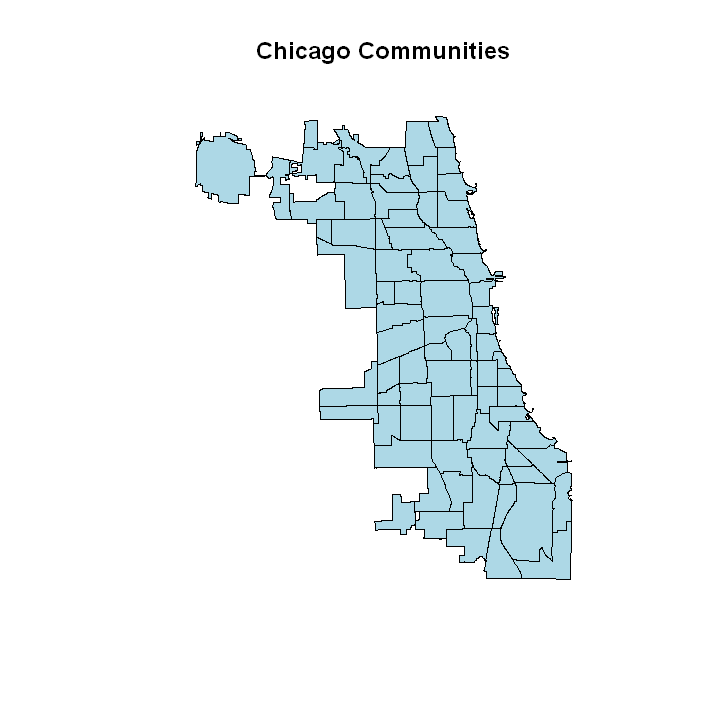

In [4]:
plot(chiPoly, 
         col = "lightblue", 
         lwd = 0.2, 
         main = "Chicago Communities")

## Load in trip and socioeconomic data

In [5]:
# load in taxi trips with socioeconomic data

taxi <- read.csv("data/2016/trip_socioeconomic_joined.csv")

# Remove TaxiId
taxi <- taxi %>%
    select(-taxi_id)

In [6]:
t(head(taxi, 2))

,1,2
tolls,0,0
trip_start_timestamp,10/30/2016 01:00 AM,10/21/2016 05:30 PM
trip_end_timestamp,10/30/2016 01:15 AM,10/21/2016 05:45 PM
company,Blue Ribbon Taxi Association Inc.,Taxi Affiliation Services
dropoff_centroid_longitude,-87.67017,-87.66342
dropoff_centroid_latitude,42.00962,41.98671
fare,11.50,6.75
payment_type,Credit Card,Cash
pickup_centroid_latitude,41.96581,41.96581
pickup_centroid_longitude,-87.65588,-87.65588


In [7]:
nrow(taxi)

[1] 527014

### Remove outliers

In [8]:
summary(taxi$trip_total)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    7.25    9.75   15.06   15.25 6716.36 

In [9]:
tripEarningsIQR <- IQR(taxi$trip_total)

lowerQ <- quantile(taxi$trip_total)[[2]]
upperQ <- quantile(taxi$trip_total)[[4]]

upperThreshold <- (tripEarningsIQR * 1.5) + upperQ
lowerThreshold <- 1 # price cannot be lower than $1

print(upperThreshold)
print(lowerThreshold)

[1] 27.25
[1] 1


In [10]:
taxi <- taxi %>% 
    filter(trip_total <= upperThreshold & trip_total >= lowerThreshold)

summary(taxi$trip_total)
print(nrow(taxi))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    7.00    9.00   10.23   12.30   27.25 

[1] 460642


### Convert to spatial data

In [11]:
# convert the long/lats to spatial point data

pickupLats <- taxi$pickup_centroid_latitude
pickupLongs <- taxi$pickup_centroid_longitude

# get other attributes
tripEarnings <- taxi$trip_total
communityAreaNumber <- taxi$CommunityAreaNumber
communityAreaName <- taxi$CommunityAreaName
percentCapitaIncome <- taxi$PercentCapitaIncome

# create dataframe
data <- data.frame(tripEarnings, percentCapitaIncome, pickupLats, pickupLongs)
head(data)

tripEarnings,percentCapitaIncome,pickupLats,pickupLongs
14.50,35787,41.96581,-87.65588
6.75,35787,41.96581,-87.65588
21.75,35787,41.96581,-87.65588
3.75,35787,41.96581,-87.65588
23.75,35787,41.95815,-87.65302
16.50,35787,41.95815,-87.65302


In [12]:
# combine the x and y coordinates

ptcoords <- cbind(as.numeric(pickupLongs), as.numeric(pickupLats))
head(ptcoords)

-87.65588,41.96581
-87.65588,41.96581
-87.65588,41.96581
-87.65588,41.96581
-87.65302,41.95815
-87.65302,41.95815


In [13]:
df <- SpatialPointsDataFrame(ptcoords, data = data)
head(df)

            coordinates tripEarnings percentCapitaIncome pickupLats pickupLongs
1 (-87.65588, 41.96581)        14.50               35787   41.96581   -87.65588
2 (-87.65588, 41.96581)         6.75               35787   41.96581   -87.65588
3 (-87.65588, 41.96581)        21.75               35787   41.96581   -87.65588
4 (-87.65588, 41.96581)         3.75               35787   41.96581   -87.65588
5 (-87.65302, 41.95815)        23.75               35787   41.95815   -87.65302
6 (-87.65302, 41.95815)        16.50               35787   41.95815   -87.65302

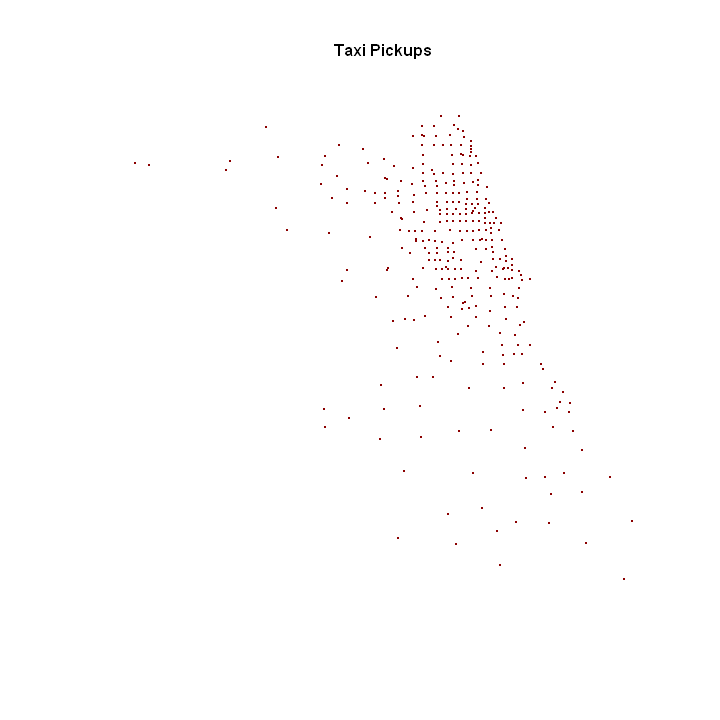

In [14]:
# plot the points

plot(df, col = "darkred", pch = 20, cex = 0.2, lwd = 0.2, 
        main = "Taxi Pickups", cex.main = 0.8)

### Standardize the Coordinate Reference Systems (CRS)

In [15]:
newCRS <- CRS("+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 +init=epsg:32610")

chiPoly <- spTransform(chiPoly, newCRS)
proj4string(df) <- newCRS
df <- spTransform(df, newCRS)

In [16]:
summary(df)

Object of class SpatialPointsDataFrame
Coordinates:
                min       max
coords.x1 -87.91362 -87.53490
coords.x2  41.66367  42.01601
Is projected: FALSE 
proj4string :
[+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0
+init=epsg:32610 +units=m]
Number of points: 460642
Data attributes:
  tripEarnings   percentCapitaIncome   pickupLats     pickupLongs    
 Min.   : 1.00   Min.   :10402       Min.   :41.66   Min.   :-87.91  
 1st Qu.: 7.00   1st Qu.:60058       1st Qu.:41.88   1st Qu.:-87.64  
 Median : 9.00   Median :65526       Median :41.89   Median :-87.63  
 Mean   :10.23   Mean   :67997       Mean   :41.90   Mean   :-87.64  
 3rd Qu.:12.30   3rd Qu.:88669       3rd Qu.:41.90   3rd Qu.:-87.63  
 Max.   :27.25   Max.   :88669       Max.   :42.02   Max.   :-87.53  

In [17]:
summary(chiPoly)

Object of class SpatialPolygonsDataFrame
Coordinates:
        min       max
x -87.94011 -87.52414
y  41.64454  42.02304
Is projected: FALSE 
proj4string :
[+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0
+init=epsg:32610 +units=m]
Data attributes:
   perimeter          community    shape_len        shape_area       
 Min.   :0   ALBANY PARK   : 1   Min.   : 18138   Min.   : 16913961  
 1st Qu.:0   ARCHER HEIGHTS: 1   1st Qu.: 31949   1st Qu.: 49769639  
 Median :0   ARMOUR SQUARE : 1   Median : 43229   Median : 79635753  
 Mean   :0   ASHBURN       : 1   Mean   : 44398   Mean   : 83614533  
 3rd Qu.:0   AUBURN GRESHAM: 1   3rd Qu.: 49478   3rd Qu.: 98853168  
 Max.   :0   AUSTIN        : 1   Max.   :173626   Max.   :371835608  
             (Other)       :71                                       
      area      comarea    area_numbe   area_num_1   comarea_id
 Min.   :0   Min.   :0   1      : 1   1      : 1   Min.   :0   
 1st Qu.:0   1st Qu.:0   10     : 1   10     : 1

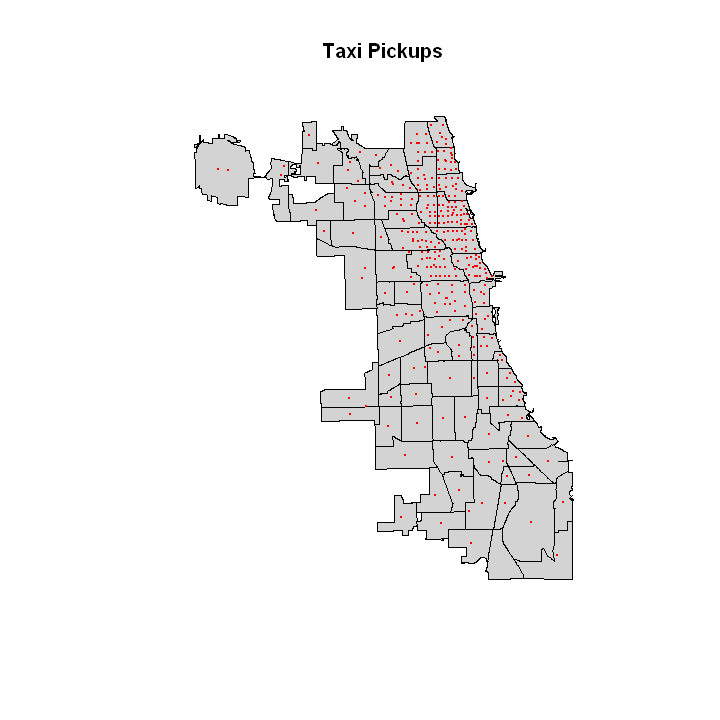

In [18]:
plot(chiPoly, col = "lightgray", main = "Taxi Pickups", cex.main = 1, lwd = 0.2)
plot(df, col = "red", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=41.839841,-87.724264&zoom=11&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Warning message:
"Removed 1524 rows containing missing values (geom_point)."

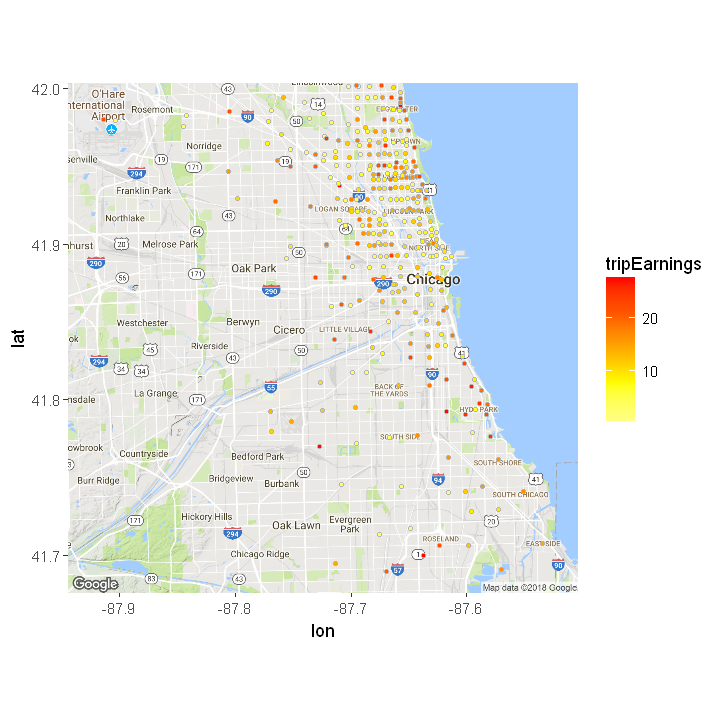

In [19]:
map <- get_map(location=rowMeans(bbox(df)), zoom = 11)

ggmap(map) + 
  geom_point(data = as.data.frame(df), 
             aes(pickupLongs, pickupLats, fill = tripEarnings), 
             color = "grey70", size = 1, shape = 21) +
  scale_fill_gradientn(colours=rev(heat.colors(5)))

###  Join the trips data with the Chicago polygon
This way, we only need to do analysis on a single set

In [20]:
taxiSummary <- taxi %>%
    group_by(CommunityAreaNumber) %>%
    summarize(
              numberTrips = n(),
              avgTotal = mean(trip_total),
              avgTip = median(tips),
              avgFare = median(fare),
              avgMile = median(trip_miles),
              avgSeconds = median(trip_seconds),
              HardshipIndex = mean(HardshipIndex),
              PercentCapitaIncome = mean(PercentCapitaIncome),
              PercentUnder18OrOver64 = mean(PercentUnder18OrOver64),
              PercentBelowPoverty = mean(PercentBelowPoverty),
              PercentNoHsDiploma = mean(PercentNoHsDiploma),
              PercentUnemployed = mean(PercentUnemployed), 
              PercentHousingCrowded = mean(PercentHousingCrowded))

head(taxiSummary, 5)

CommunityAreaNumber,numberTrips,avgTotal,avgTip,avgFare,avgMile,avgSeconds,HardshipIndex,PercentCapitaIncome,PercentUnder18OrOver64,PercentBelowPoverty,PercentNoHsDiploma,PercentUnemployed,PercentHousingCrowded
1,1548,10.169438,0,7.25,0.3,420,39,23939,27.5,23.6,18.2,8.7,7.7
2,1500,8.418867,0,6.75,0.0,360,46,23040,38.5,17.2,20.8,8.8,7.8
3,6916,11.651709,0,9.00,0.5,540,20,35787,22.2,24.0,11.8,8.9,3.8
4,1724,10.969588,0,8.75,0.6,540,17,37524,25.5,10.9,13.4,8.2,3.4
5,2220,11.753482,0,9.50,0.8,600,6,57123,26.2,7.5,4.5,5.2,0.3


In [21]:
mergedPoly <- merge(x = chiPoly@data, y = taxiSummary, by.x = "area_numbe", by.y = "CommunityAreaNumber", all = TRUE)

## Let's look through the taxi data for Chicago


Warning message in classIntervals(mergedPoly$avgTotal, numcat, style = "kmeans"):
"var has missing values, omitted in finding classes"

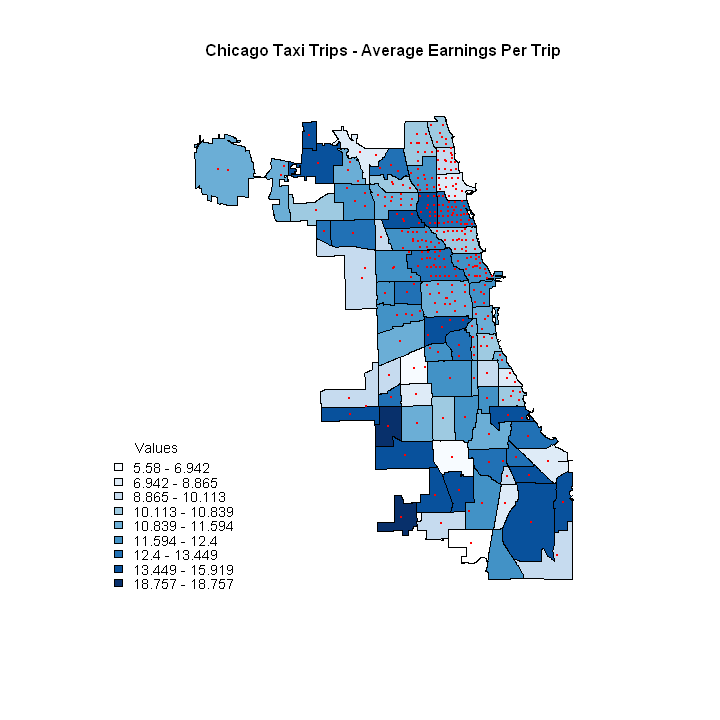

In [22]:
numcat <- 9
pal <- brewer.pal(numcat,"Blues")
q <- classIntervals(mergedPoly$avgTotal, numcat, style = "kmeans")
cols <- findColours(q, pal)

plot(chiPoly, col = cols, lwd = 0.2, main = "Chicago Taxi Trips - Average Earnings Per Trip", cex.main = 0.8)
plot(df, col = "red", border = "grey", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Values", cex = 0.7)

Warning message in classIntervals(mergedPoly$numberTrips, numcat, style = "kmeans"):
"var has missing values, omitted in finding classes"

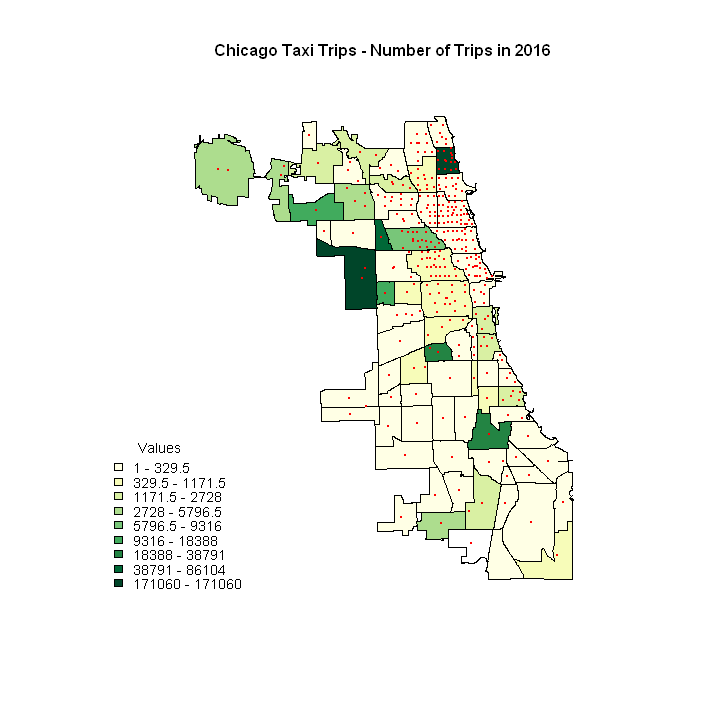

In [23]:
numcat <- 9
pal <- brewer.pal(numcat,"YlGn")
q <- classIntervals(mergedPoly$numberTrips, numcat, style = "kmeans")
cols <- findColours(q, pal)

plot(chiPoly, col = cols, lwd = 0.2, main = "Chicago Taxi Trips - Number of Trips in 2016", cex.main = 0.8)
plot(df, col = "red", border = "grey", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Values", cex = 0.7)

Warning message in classIntervals(mergedPoly$avgMile, numcat, style = "kmeans"):
"var has missing values, omitted in finding classes"

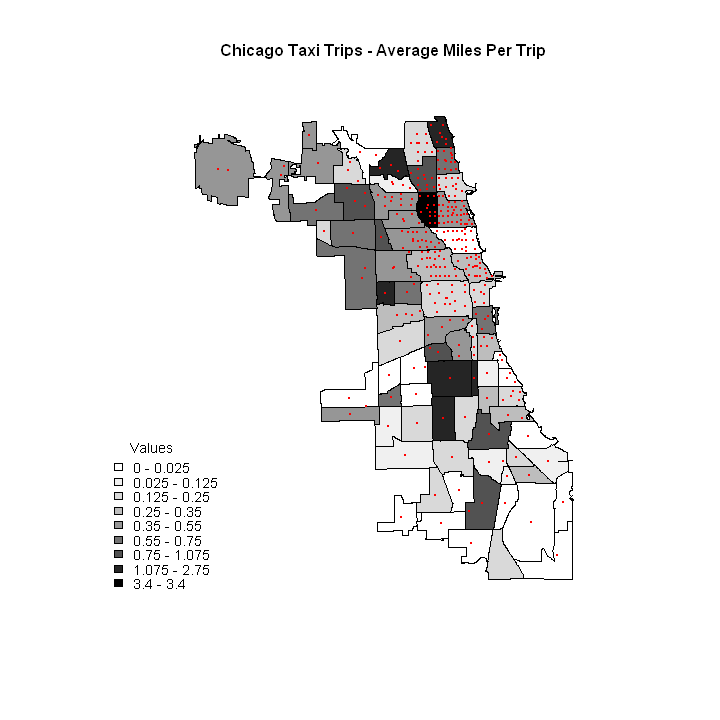

In [24]:
numcat <- 9
pal <- brewer.pal(numcat,"Greys")
q <- classIntervals(mergedPoly$avgMile, numcat, style = "kmeans")
cols <- findColours(q, pal)

plot(chiPoly, col = cols, lwd = 0.2, main = "Chicago Taxi Trips - Average Miles Per Trip", cex.main = 0.8)
plot(df, col = "red", border = "grey", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Values", cex = 0.7)

## Let's look through the socioeconomic data for Chicago

Warning message in classIntervals(mergedPoly$PercentCapitaIncome, numcat, style = "kmeans"):
"var has missing values, omitted in finding classes"

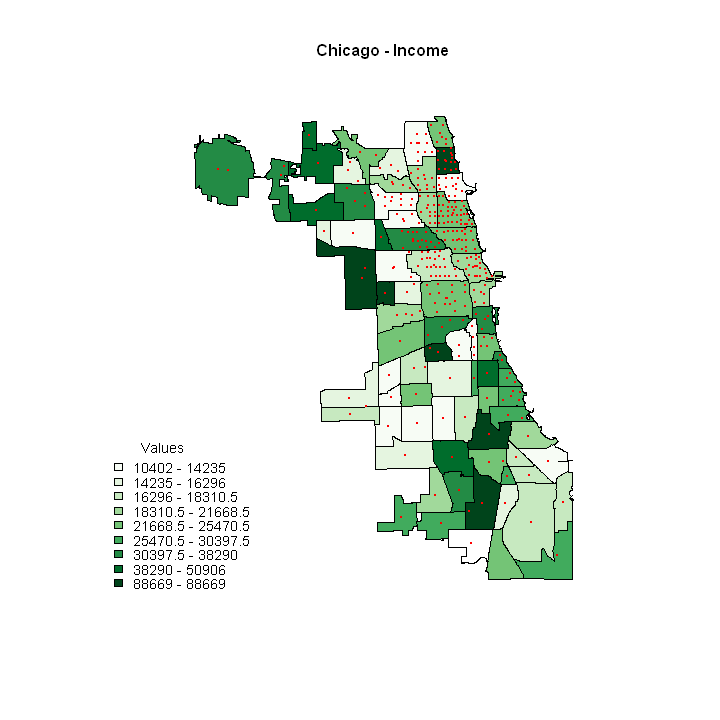

In [25]:
numcat <- 9
pal <- brewer.pal(numcat,"Greens")
q <- classIntervals(mergedPoly$PercentCapitaIncome, numcat, style = "kmeans")
cols <- findColours(q, pal)

plot(chiPoly, col = cols, lwd = 0.2, main = "Chicago - Income", cex.main = 0.8)
plot(df, col = "red", border = "grey", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Values", cex = 0.7)

Warning message in classIntervals(mergedPoly$HardshipIndex, numcat, style = "kmeans"):
"var has missing values, omitted in finding classes"

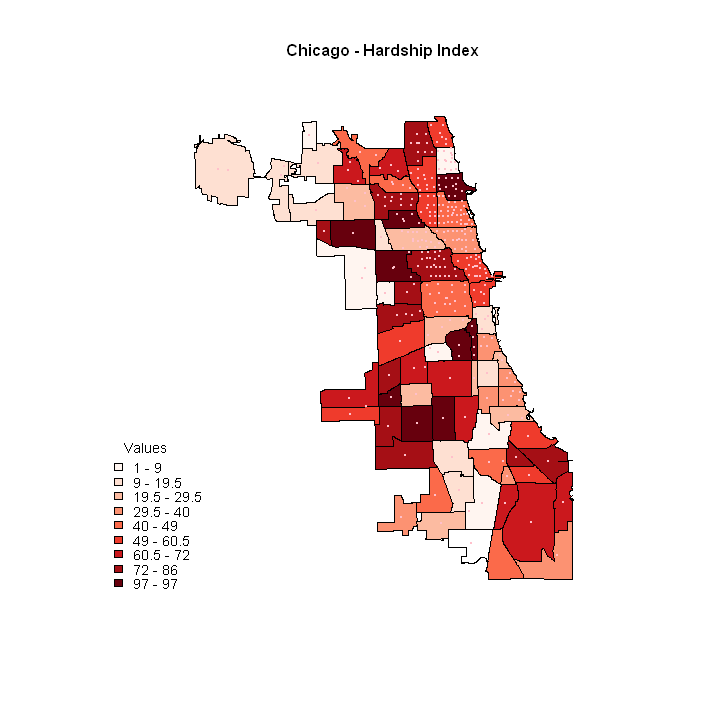

In [26]:
numcat <- 9
pal <- brewer.pal(numcat,"Reds")
q <- classIntervals(mergedPoly$HardshipIndex, numcat, style = "kmeans")
cols <- findColours(q, pal)

plot(chiPoly, col = cols, lwd = 0.2, main = "Chicago - Hardship Index", cex.main = 0.8)
plot(df, col = "pink", border = "grey", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Values", cex = 0.7)

Warning message in classIntervals(mergedPoly$PercentBelowPoverty, numcat, style = "kmeans"):
"var has missing values, omitted in finding classes"

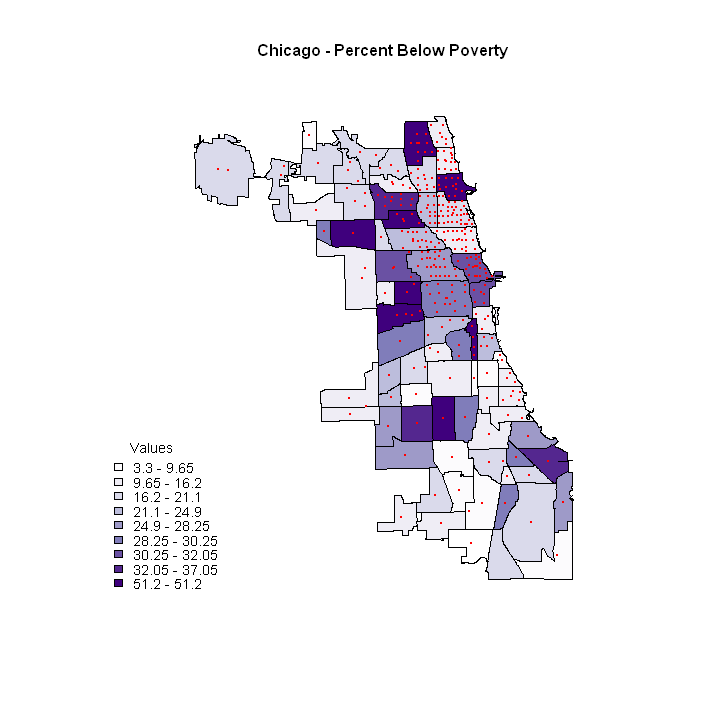

In [27]:
numcat <- 9
pal <- brewer.pal(numcat,"Purples")
q <- classIntervals(mergedPoly$PercentBelowPoverty, numcat, style = "kmeans")
cols <- findColours(q, pal)

plot(chiPoly, col = cols, lwd = 0.2, main = "Chicago - Percent Below Poverty", cex.main = 0.8)
plot(df, col = "red", border = "grey", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Values", cex = 0.7)

Warning message in classIntervals(mergedPoly$PercentNoHsDiploma, numcat, style = "kmeans"):
"var has missing values, omitted in finding classes"

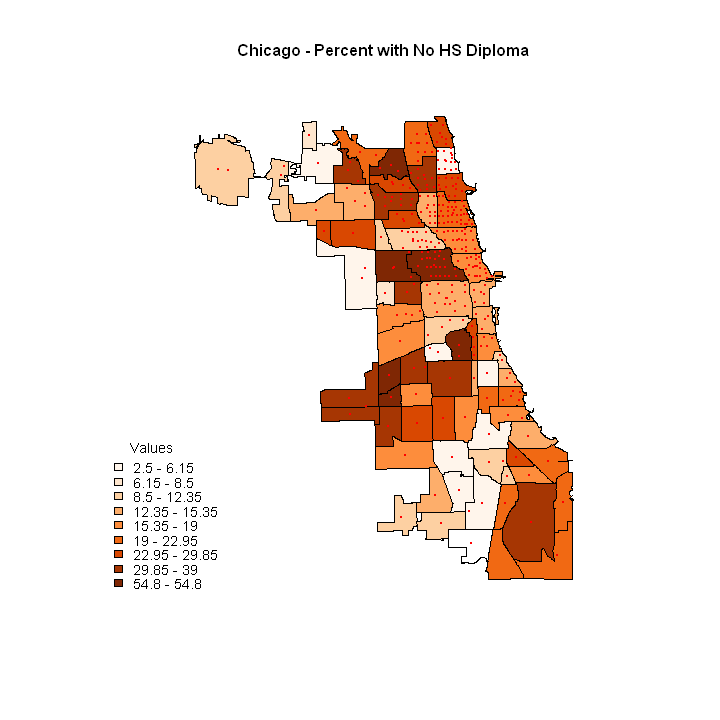

In [28]:
numcat <- 9
pal <- brewer.pal(numcat,"Oranges")
q <- classIntervals(mergedPoly$PercentNoHsDiploma, numcat, style = "kmeans")
cols <- findColours(q, pal)

plot(chiPoly, col = cols, lwd = 0.2, main = "Chicago - Percent with No HS Diploma", cex.main = 0.8)
plot(df, col = "red", border = "grey", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Values", cex = 0.7)

In [29]:
# do spatial autocorrelation